In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

In [2]:
g = nx.read_graphml("./graph/train_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0).astype('uint8')
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("uint8")
df_agg = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [5]:
mol_rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0)

In [6]:
mol_rdkit

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
COc1cc2c3c(ccnc3c1OC)NC=C2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC(C)CCCC(C)C1CCC2C3=CCC4CC(O)CCC4(C)C3CCC21C,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
CC(C)CCCC(C)C1CCC2C3CCC4CC(O)CCC4(C)C3CCC12C,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
COC1=Cc2ccnc3c2C1(O)C(CC(C)=O)=NC=C3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nc1c(O)c2c3c(c1Cc1ccc(O)cc1)=NCCC=3C=N2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
O=C1C(=O)c2[nH]cc3c2C(=C1Cl)NCC3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O=C1C(NCCc2ccccc2)=CC2=NCCc3c[nH]c1c32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc(C=CNc2cc3c4c(c2O)N=CC=4CCN=3)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [3]:
species_test = species_features_dummy[~species_features_dummy.index.isin(df_agg.organism_name)].index
mol_test = molecule_features_dummy[~molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)].index

In [4]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [5]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_feat,
                                              'molecule': molecule_feat},
                              dtype='uint8')
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 149920, Edges: 613300

 Node types:
  molecule: [115623]
    Features: uint8 vector, length 27
    Edge types: molecule-present_in->species
  species: [34297]
    Features: uint8 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [306650]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [306650]
        Weights: all 1 (default)
        Features: none


In [6]:
batch_size = 128 #default: 200
epochs = 30 #default: 20
num_samples = [3, 1]
num_workers = multiprocessing.cpu_count()-2

In [7]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="has"
)

Network has 306650 edges of type has
Network has 306650 edges of type has
** Sampled 30665 positive and 30665 negative edges. **


In [8]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="has"
)

Network has 275985 edges of type has
Network has 275985 edges of type has
** Sampled 27598 positive and 27598 negative edges. **


In [9]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 149920, Edges: 555037

 Node types:
  molecule: [115623]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [34297]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    molecule-present_in->species: [306650]
        Weights: all 1 (default)
        Features: none
    species-has->molecule: [248387]
        Weights: all 1 (default)
        Features: none


In [10]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 149920, Edges: 582635

 Node types:
  molecule: [115623]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [34297]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    molecule-present_in->species: [306650]
        Weights: all 1 (default)
        Features: none
    species-has->molecule: [275985]
        Weights: all 1 (default)
        Features: none


In [11]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["species", "molecule"],
                                seed=42)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True, seed=42)

In [12]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["species", "molecule"],
                               seed=42)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, seed=42)

In [13]:
hinsage_layer_sizes = [1024, 1024]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['elu','selu'])

In [14]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [15]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [16]:
model = keras.Model(inputs=x_inp, outputs=prediction)

initial_learning_rate = 0.1
final_learning_rate = 0.001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(edge_ids_train.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [17]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

432/432 - 7s - loss: 0.6941 - auc: 0.4970 - 7s/epoch - 16ms/step
480/480 - 7s - loss: 0.6940 - auc: 0.5007 - 7s/epoch - 14ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6941
	auc: 0.4970

Test Set Metrics of the initial (untrained) model:
	loss: 0.6940
	auc: 0.5007


In [18]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=5,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/30
432/432 - 31s - loss: 0.5842 - auc: 0.7430 - val_loss: 0.4441 - val_auc: 0.8740 - 31s/epoch - 72ms/step
Epoch 2/30
432/432 - 24s - loss: 0.4310 - auc: 0.8783 - val_loss: 0.3408 - val_auc: 0.9302 - 24s/epoch - 56ms/step
Epoch 3/30
432/432 - 27s - loss: 0.3486 - auc: 0.9230 - val_loss: 0.2722 - val_auc: 0.9537 - 27s/epoch - 62ms/step
Epoch 4/30
432/432 - 30s - loss: 0.3067 - auc: 0.9407 - val_loss: 0.2463 - val_auc: 0.9614 - 30s/epoch - 68ms/step
Epoch 5/30
432/432 - 24s - loss: 0.2795 - auc: 0.9508 - val_loss: 0.2226 - val_auc: 0.9692 - 24s/epoch - 56ms/step
Epoch 6/30
432/432 - 29s - loss: 0.2561 - auc: 0.9588 - val_loss: 0.2085 - val_auc: 0.9736 - 29s/epoch - 68ms/step
Epoch 7/30
432/432 - 30s - loss: 0.2432 - auc: 0.9626 - val_loss: 0.1968 - val_auc: 0.9765 - 30s/epoch - 69ms/step
Epoch 8/30
432/432 - 27s - loss: 0.2280 - auc: 0.9671 - val_loss: 0.1885 - val_auc: 0.9772 - 27s/epoch - 62ms/step
Epoch 9/30
432/432 - 25s - loss: 0.2208 - auc: 0.9690 - val_loss: 0.1870 - val_a

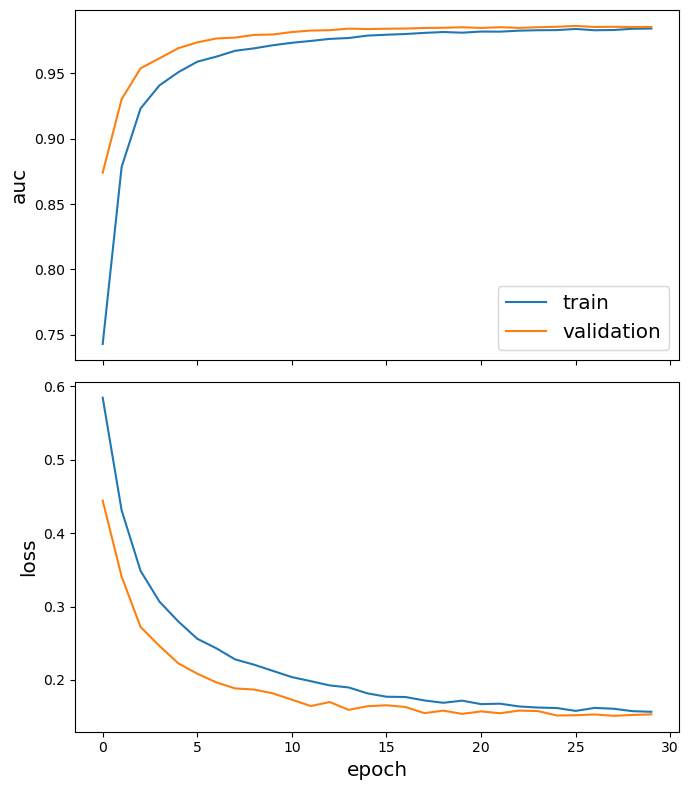

In [19]:
sg.utils.plot_history(history)

In [20]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

432/432 - 7s - loss: 0.1124 - auc: 0.9914 - 7s/epoch - 15ms/step
480/480 - 7s - loss: 0.1508 - auc: 0.9860 - 7s/epoch - 15ms/step

Train Set Metrics of the trained model:
	loss: 0.1124
	auc: 0.9914

Test Set Metrics of the trained model:
	loss: 0.1508
	auc: 0.9860


In [21]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [22]:
test_pred = HinSAGELinkGenerator(G,
                                 batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["species", "molecule"],
                                seed=42).flow(edge_ids_test, edge_labels_test, seed=42)

In [23]:
predictions = predict(model, test_pred)

480/480 [==============================] - 7s 13ms/step


In [24]:
middle = int(len(predictions)/2)

In [25]:
np.mean(predictions[:middle])

0.9524394

In [26]:
np.mean(predictions[middle:])

0.08892072

In [27]:
test = predictions[(predictions>0.5) | (predictions<0.5)]
test = test>0.5

In [28]:
test = test.astype('int8')

(array([24926.,  1508.,   923.,   712.,   648.,   649.,   879.,  1342.,
         3131., 26612.]),
 array([2.72981513e-08, 9.99966711e-02, 1.99993327e-01, 2.99989969e-01,
        3.99986625e-01, 4.99983251e-01, 5.99979937e-01, 6.99976563e-01,
        7.99973190e-01, 8.99969876e-01, 9.99966502e-01]),
 <BarContainer object of 10 artists>)

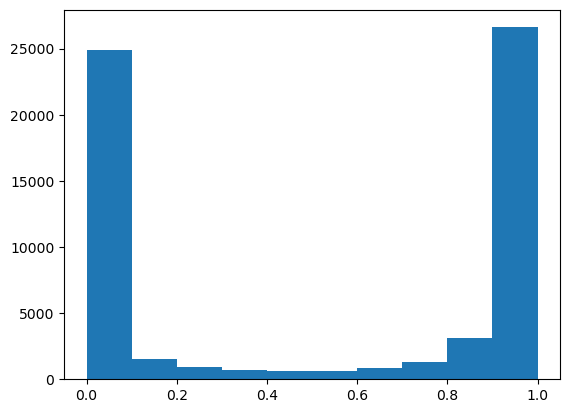

In [29]:
plt.hist(predictions)

In [30]:
np.where((predictions>0.9) | (predictions<0.1))

(array([    0,     3,     4, ..., 61327, 61328, 61329]),)

In [31]:
sum(test == edge_labels_test[np.where((predictions>0.5) | (predictions<0.5))])/len(test)

0.9634110549486385

In [32]:
len(test)/len(predictions)

1.0

In [33]:
model.save(f"./model/batch_{batch_size}_layer_{hinsage_layer_sizes[0]}_s_to_m")

INFO:tensorflow:Assets written to: ./model/batch_128_layer_1024_s_to_m/assets


INFO:tensorflow:Assets written to: ./model/batch_128_layer_1024_s_to_m/assets
